# MATH&ML-13. Временные ряды. Часть II

Александр Журавлев DST-120
***
# ЗАДАЧА ДЛЯ ПРОЕКТА

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.
***

## 0. Подготовка

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from statsmodels.tsa.seasonal import seasonal_decompose # для сезонной декомпозиции
from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера
import statsmodels.graphics.tsaplots as sgt # для построения коррелограмм
from statsmodels.tsa.arima.model import ARIMA # модель ARIMA
import pmdarima as pm # для подбора параметров ARIMA
from arch import arch_model # модель ARCH
from sklearn.linear_model import LinearRegression # модель линейной регрессии

from sklearn.metrics import mean_squared_error # для расчета метрики MSE

# убираем предупреждения
from warnings import filterwarnings
filterwarnings('ignore')

Напишем необходимые функции.

In [2]:
def plot_acf_pacf(series):
    '''
    Функция выводит коррелограммы ACF и PACF для временного ряда.
    Аргументы функции:
        series: временной ряд в виде объекта Series (например, столбец датафрейма)
    '''
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0], lags=27)
    sgt.plot_pacf(series, ax=axes[1], lags=27, method="ywm")
    plt.show()

## 1. Загрузка и знакомство с данными 

In [3]:
# загружаем данные
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col=['year'])
# упростим название столбца с данными
data.rename(columns={'GDP (current US$)':'gdp'}, inplace=True)
data

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


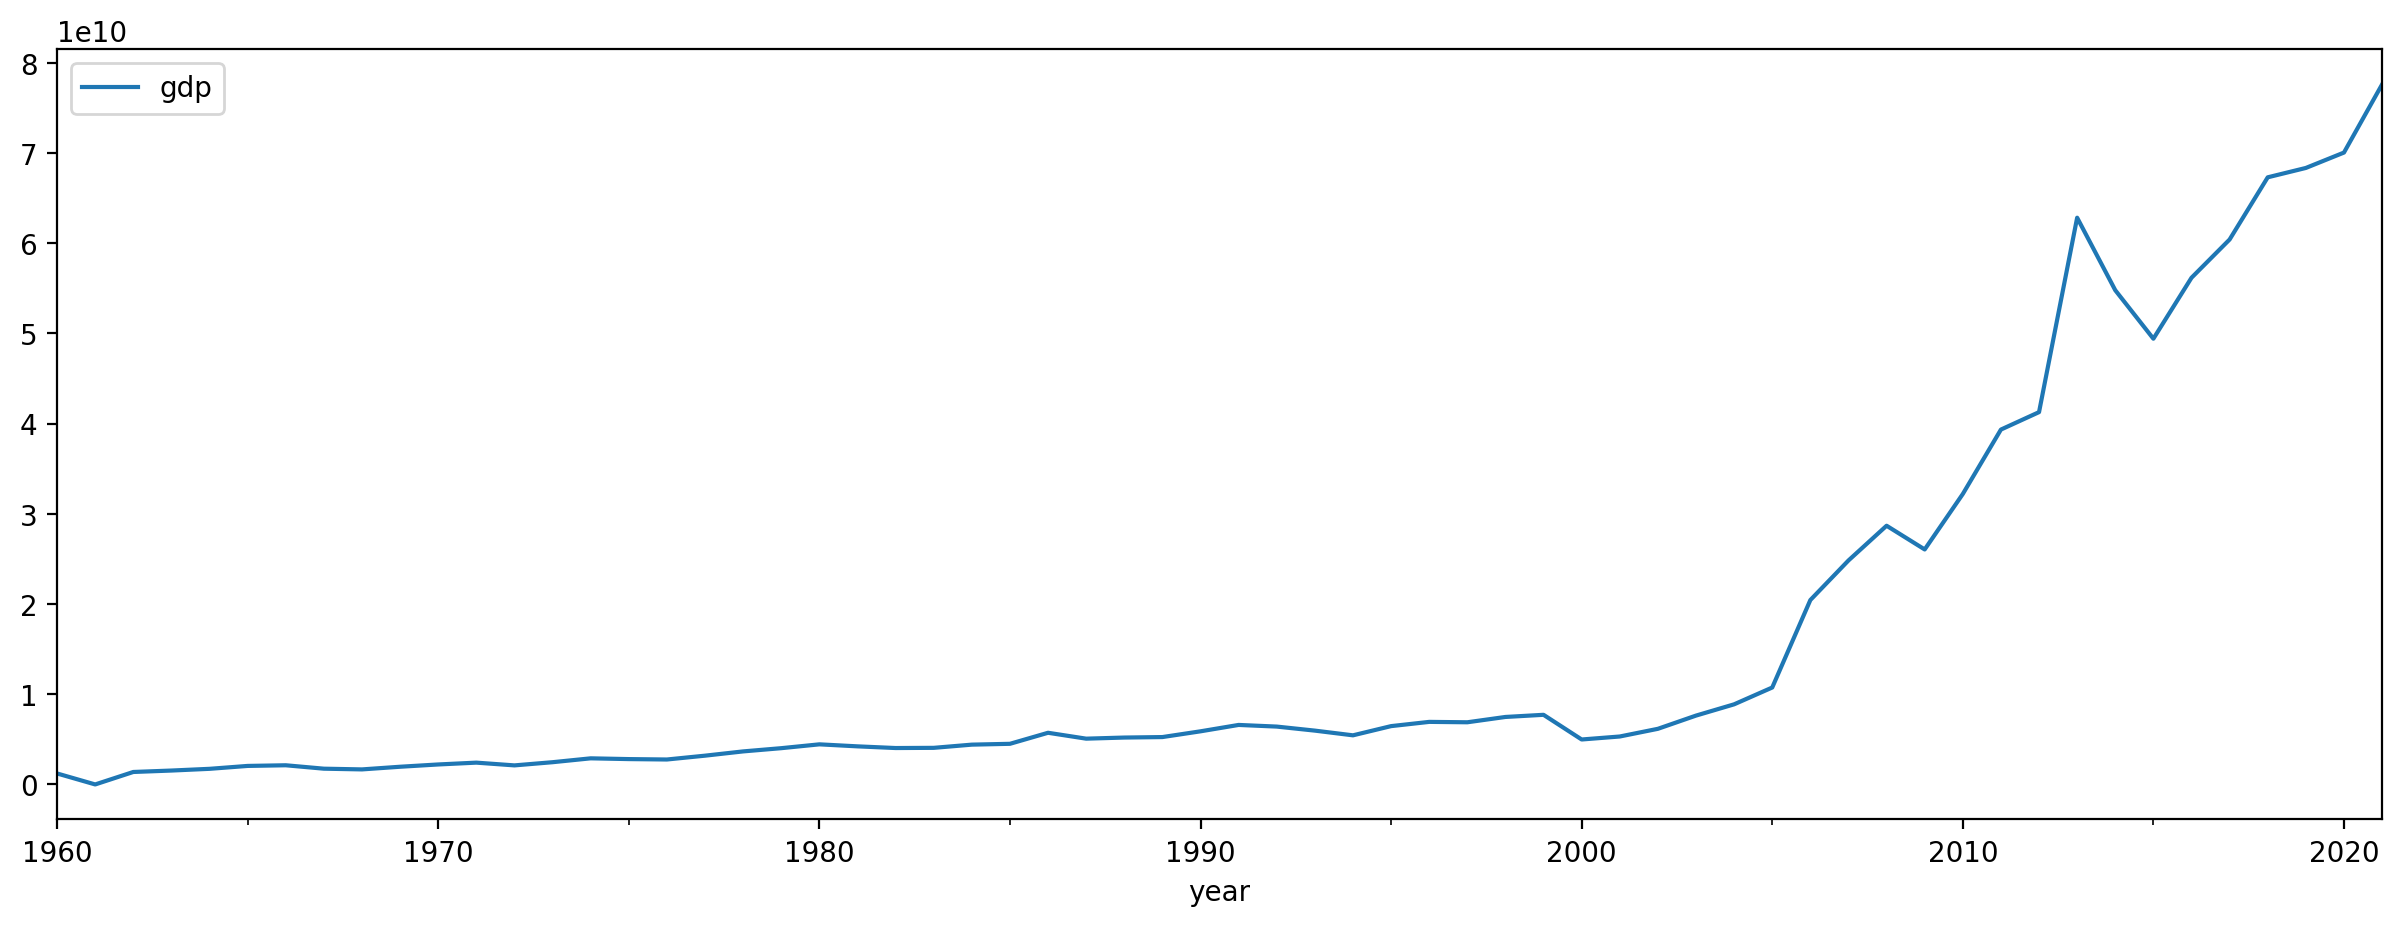

In [4]:
# первичная визуализация данных
data.plot(figsize=(15,5));

**Выводы:**
- Представленные данные охватывают период с 1960 по 2021 годы.
- Явно виден тренд на рост ВВП, правда, стоит отметить его падение, например, в 2000 году, 2009 и самое сильное падение в 2015 году, но затем мы наблюдаем снова рост.
- Данные приведены за год, сезонность в течение года мы изучить не сможем.

In [5]:
# выделим тренировочную и тестовую выборки
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":] # последние 3 года
train_df.shape, test_df.shape

((59, 1), (3, 1))

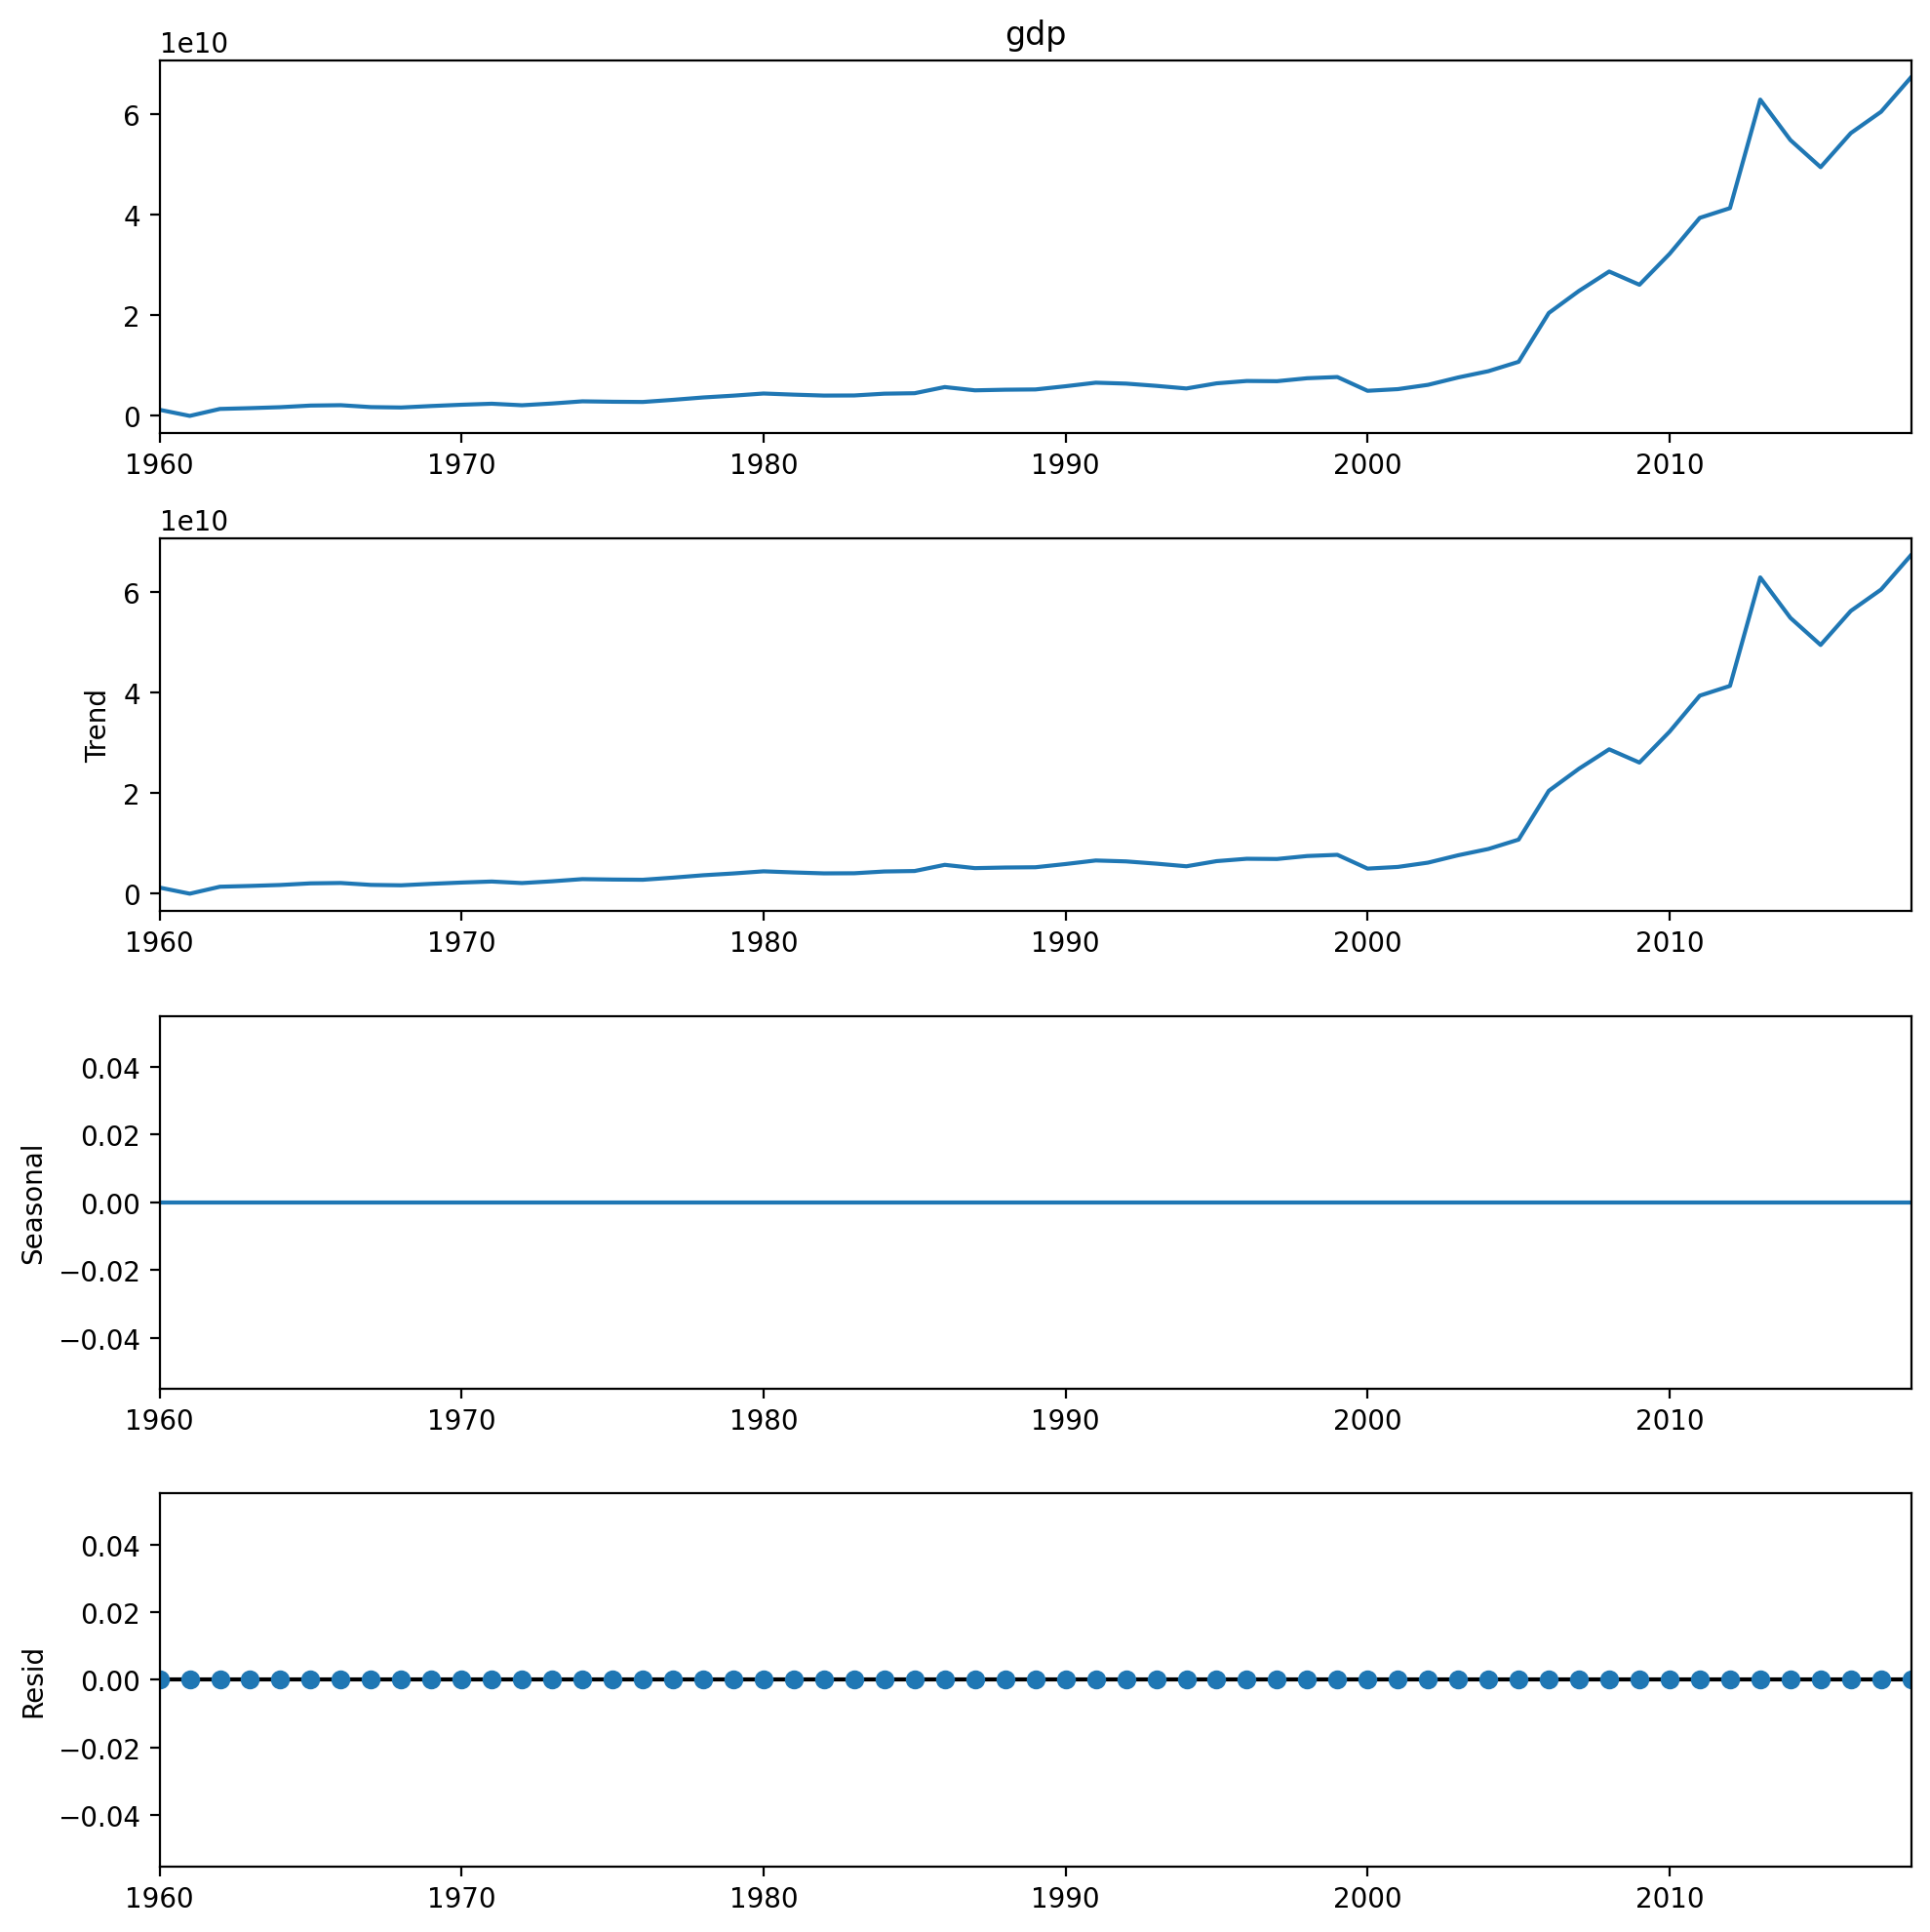

In [6]:
# сезонная декомпозиция
plt.rcParams["figure.figsize"] = 10, 10

result = seasonal_decompose(train_df.gdp)
result.plot()
plt.show()

**Выводы:**
- Мы выделили тренд, который совпадает с первоначальным графиком.
- Cезонность выделить не удалось (это логично и мы это указали выше).
- Остатки являются белым шумом с математическим ожиданием =0.

## 2. Модель скользящего среднего.

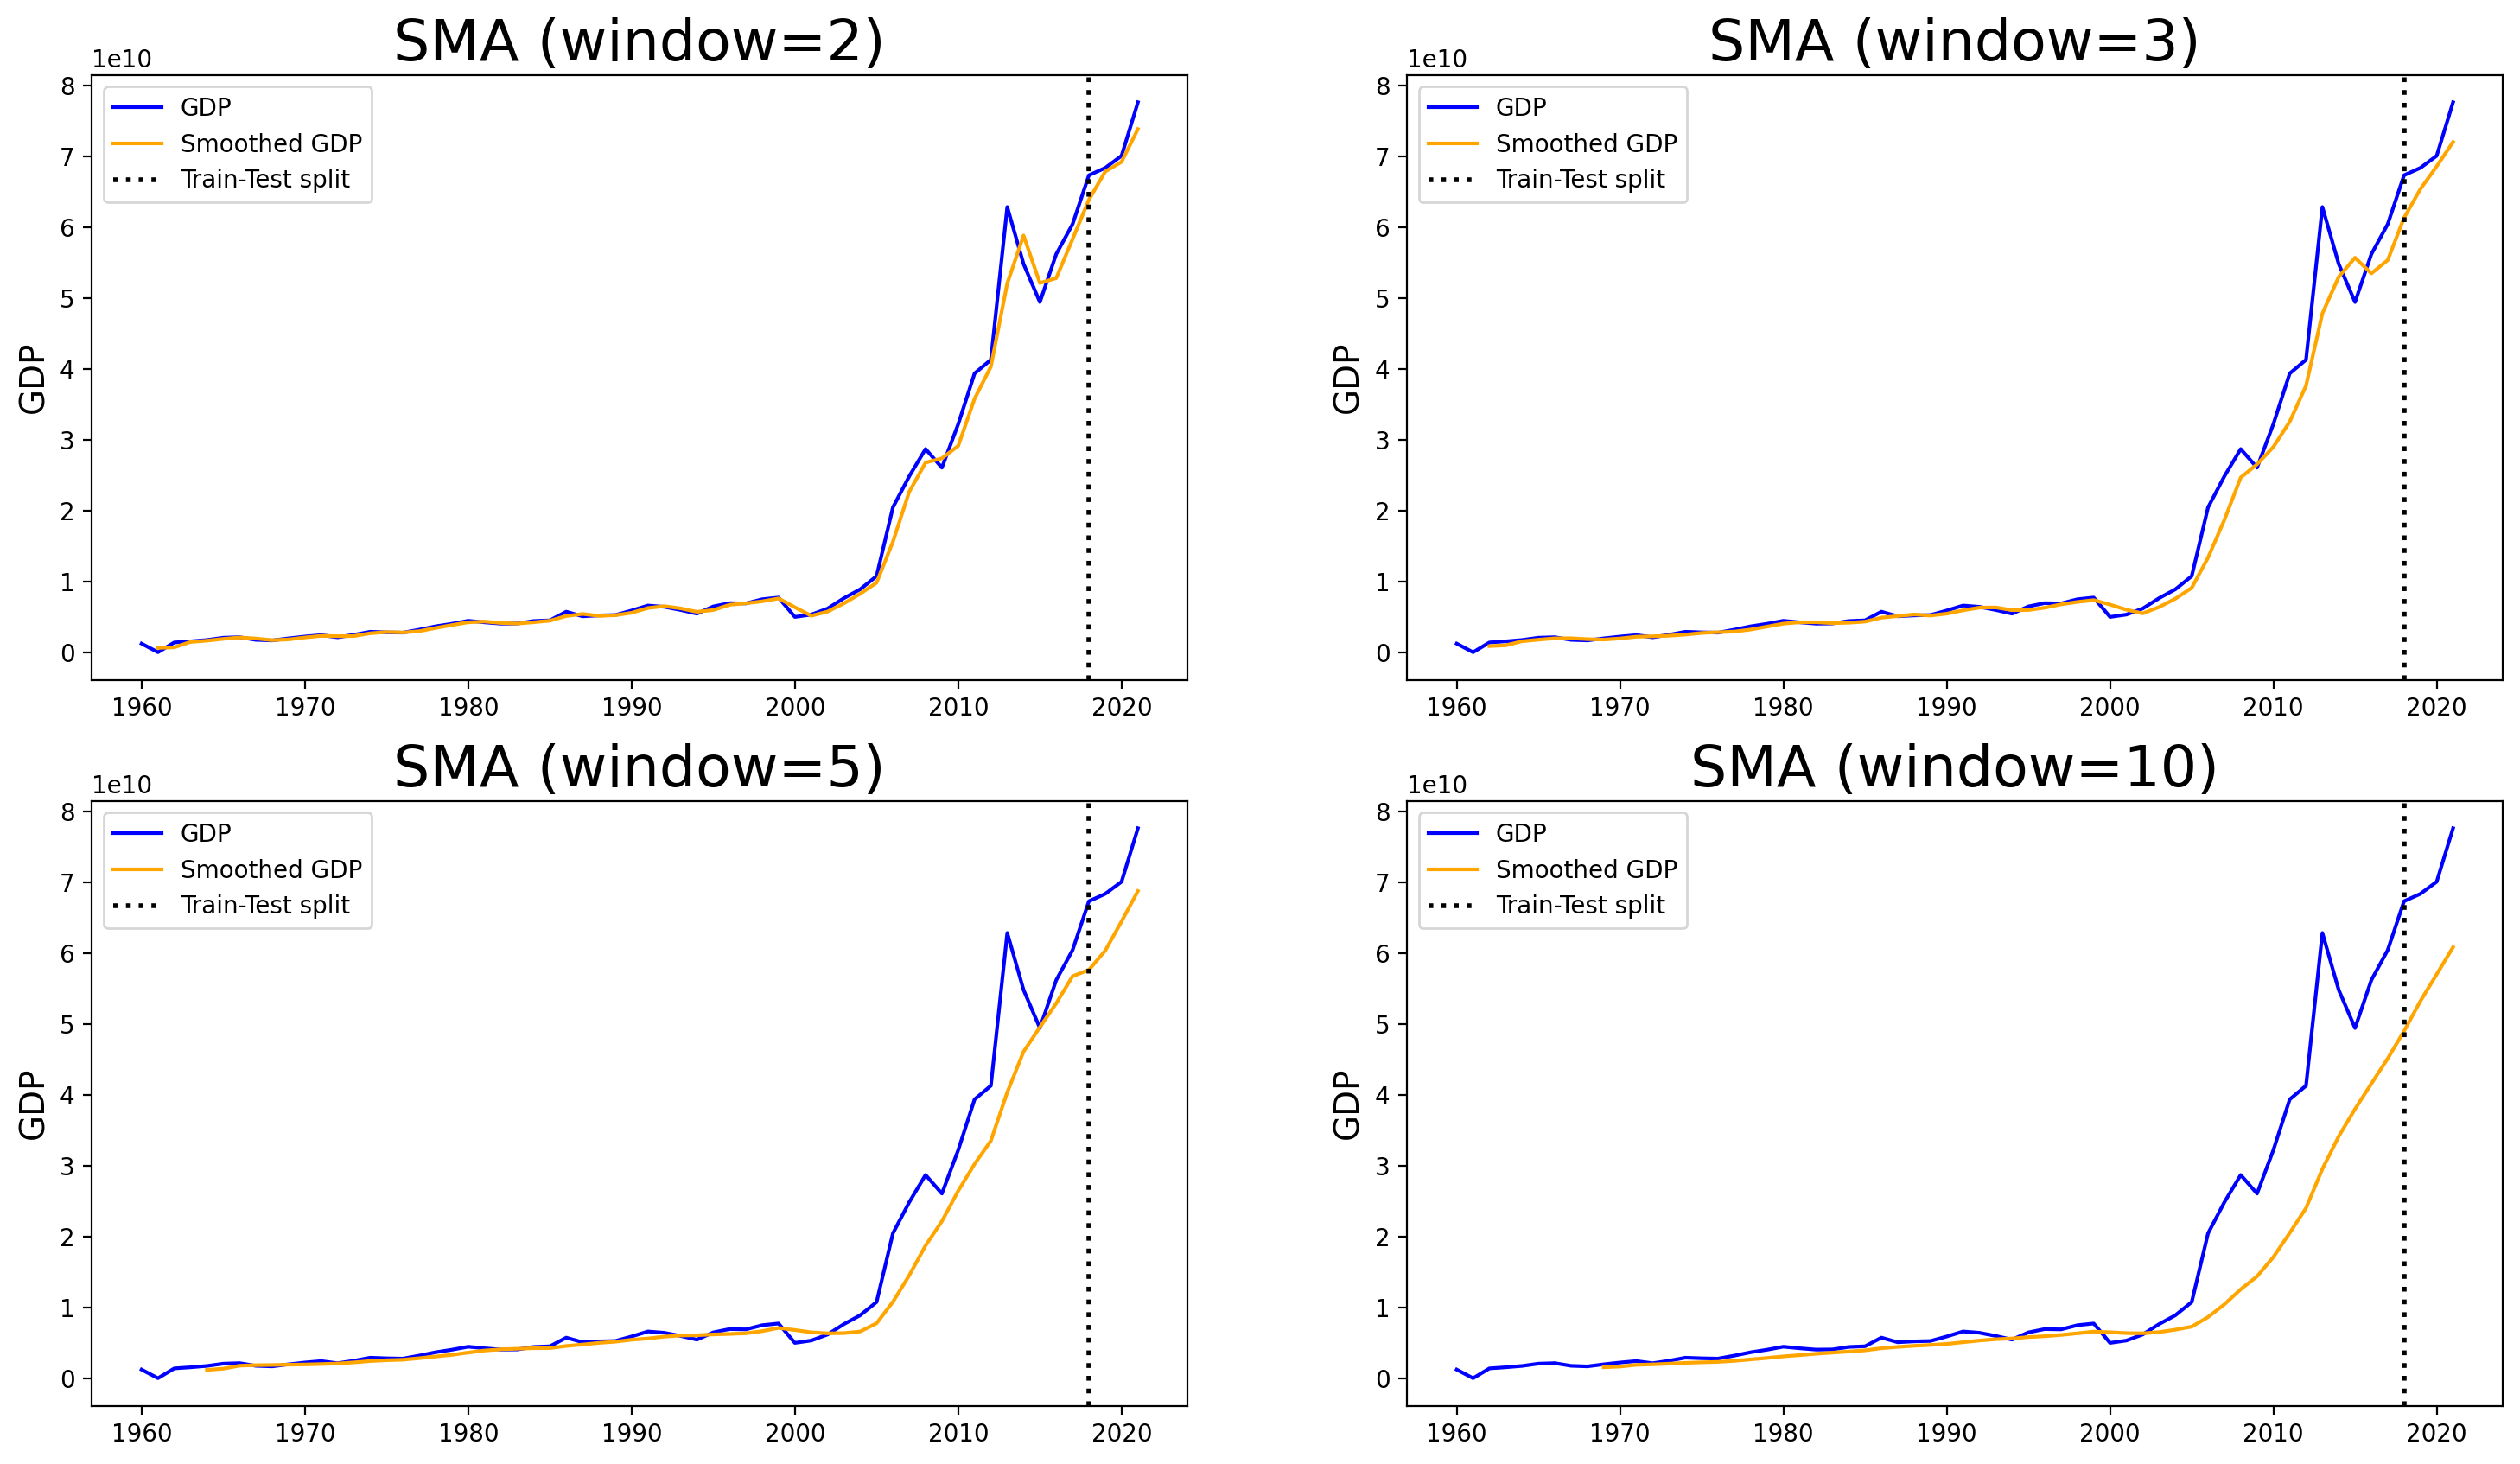

In [7]:
# значения параметра window для SMA
window_values = [2,3,5,10]

# визуализируем результаты SMA для 4-х значений window
fig = plt.figure(figsize=(18, 10))
for i, window in enumerate(window_values):
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(data.gdp, color="blue", label="GDP")
    ax.plot(
        data.gdp.rolling(window=window).mean(),
        color="orange",
        label="Smoothed GDP",
    )
    ax.axvline(x=train_df.index[-1], ls=':', lw=2, color='k', label='Train-Test split')
    ax.set_ylabel('GDP', size=14)
    ax.set_title(f"SMA (window={window})", size=24)
    ax.legend()
plt.show()

**Выводы:**
- Модель скользящего среднего позволяет повторить тренд, но плохо справляется с движениями противоположными тренду (например, падение ВВП в 2015 году).
- При движении по тренду (при низких значениях параметра *window*) прогнозные значения чаще ниже реальных, а если движение идет против тренда, то наоборот.
- При более высоких значениях параметра *window* прогнозные значения чаще ниже реальных.
- Лучший результат получен при значении *window*=2, при увеличении значения данного параметра качество модели заметно падает.

## 3. Оценка стационарности временного ряда и выбор модели ARMA/ARIMA.

In [8]:
# с помощью теста Дики-Фуллера оценим стационарность временного ряда
adfuller(train_df.gdp)

(0.6529066974885347,
 0.9888496277665572,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

**Выводы:**
- Значение из теста (самое верхнее) больше всех критических значений разного уровня значимости, а значит мы не можем отвергнуть нулевую гипотезу и ряд **не является стационарным**. 
- Следовательно, необходимо использовать модель **ARIMA** (т.к. сезонность и экзогенные факторы не учитываем).
- Необходимо найти параметр **d**, для чего будем дифференцировать временной ряд.
- Необходимо найти параметры **p** и **q** (по коррелограммам ACF и PACF).

Дифференцируем ряд до тех пор, пока он не станет стационарным.

In [9]:
# копируем тестовую выборку
train_df_adfuller = train_df.copy()
# начальный результат теста Дики-Фуллера
test_result = adfuller(train_df_adfuller['gdp'])
# счетчик разностей
i=0

# пока значение теста не станет меньше критического значения при уровне значимости 5%
# дифференцируем временной ряд
while test_result[0] > test_result[4]["5%"]:
    i+=1
    train_df_adfuller['gdp'] = train_df_adfuller['gdp'].diff()
    test_result = adfuller(train_df_adfuller['gdp'].dropna())
    print(f'{i} разность')
    print("adf: ", test_result[0])
    print("p-value: ", test_result[1])
    print("Critical values: ", test_result[4])
    if test_result[0] > test_result[4]["5%"]:
        print("ряд нестационарен\n")
    else:
        print("ряд стационарен\n")

1 разность
adf:  -1.6702483038320772
p-value:  0.4465029329713892
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен

2 разность
adf:  -2.6408690561284773
p-value:  0.08484116917837903
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен

3 разность
adf:  -4.7796237848285354
p-value:  5.9483276402248264e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен



**Вывод:** параметр **d**=3.

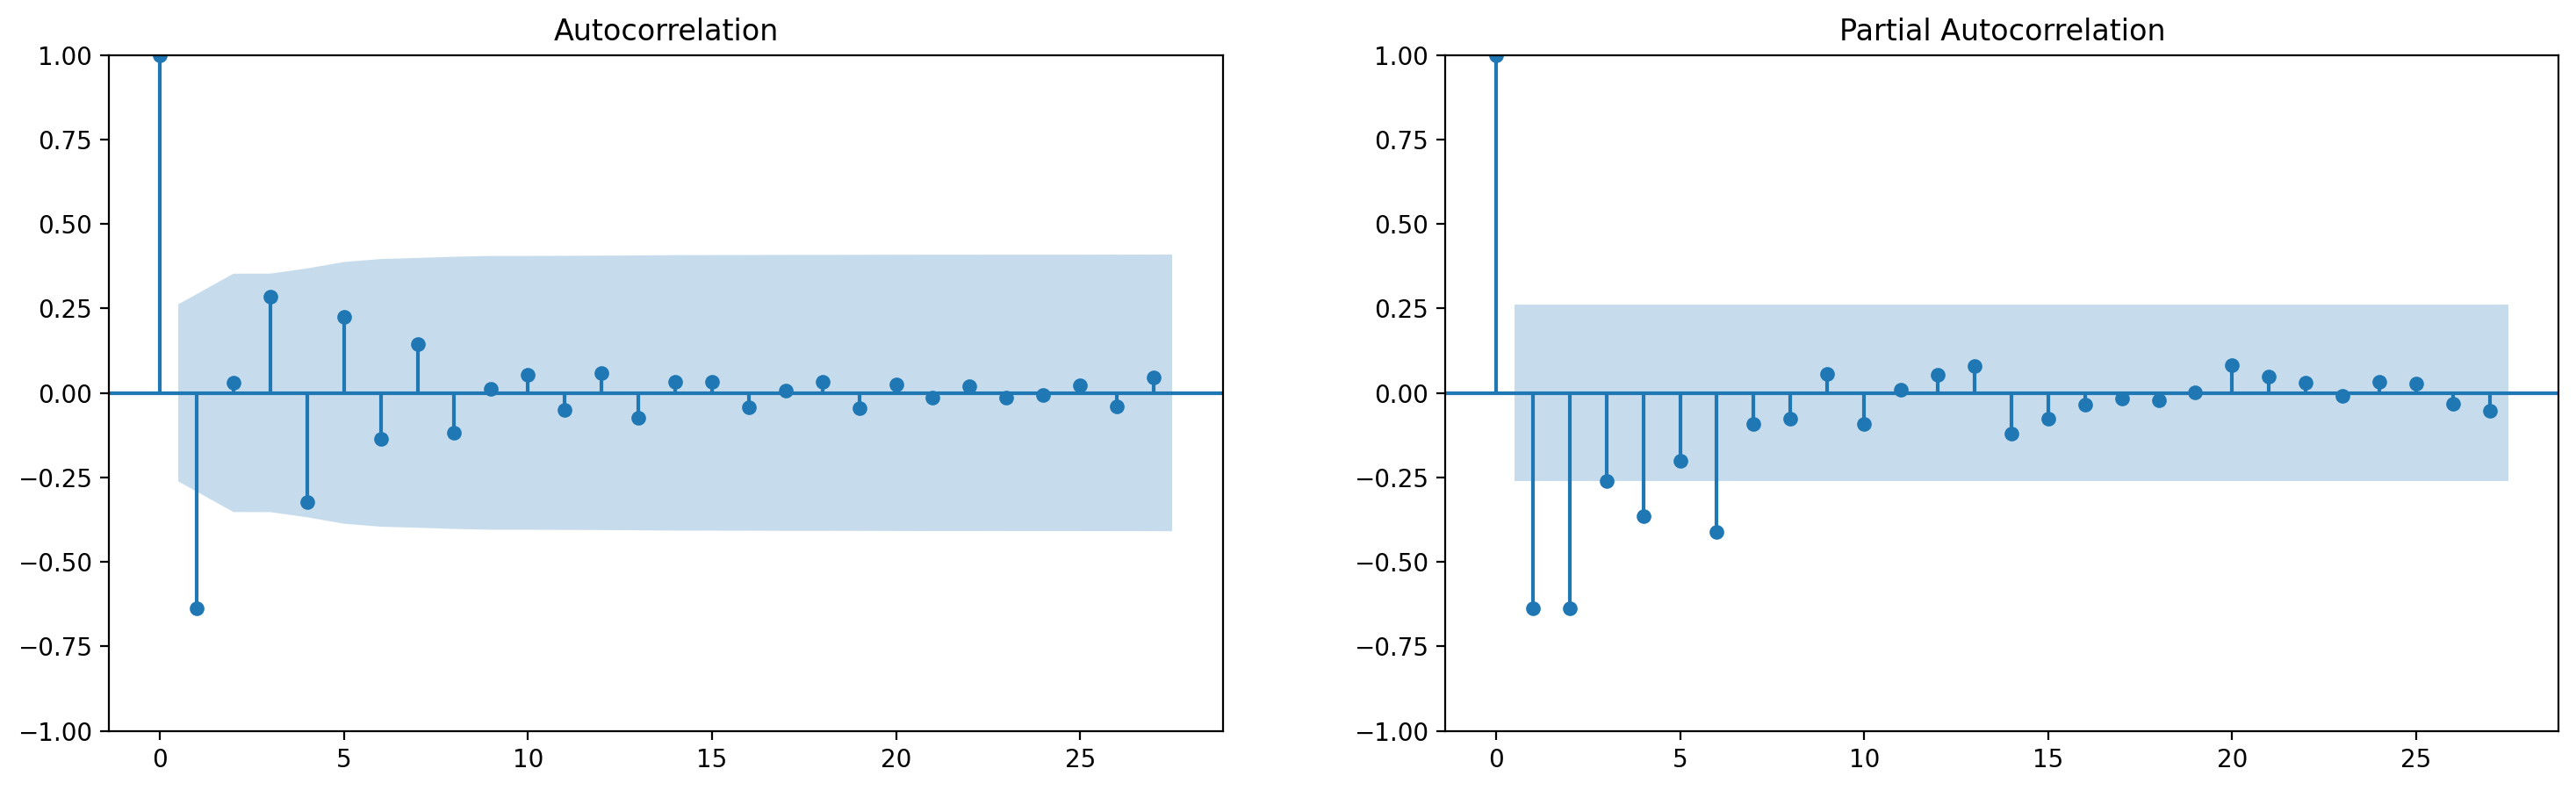

In [10]:
# выведем коррелограммы интегрированного ряда 3 порядка (он уже стационарен!)
plot_acf_pacf(train_df['gdp'].diff().diff().diff().dropna())

**Выводы:**
- На графике автокорреляции мы видим пик при лаге=1 и остальные значения в закрашенной зоне, что показывает:
    - сильную зависимость между значениям ряда и предыдущим значением
    - ряд содержит только тренд
    - остальные данные ряда, кроме первого лага, случайны и не завият от себя в прошлом
    - Параметр **q**=1
- На графике частичной автокорреляции мы видим 2 явных пика при лаге=1 и 2. Возможно, имеет смыл попробовать поиграться с лагом= 3,4,5,6.
    - Параметр **p**=2 (возможно, 3-6).

## 4. Модель ARIMA

In [11]:
# обучаем модель
arima_model = ARIMA(train_df["gdp"].dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 27 Jun 2023   AIC                           2659.231
Time:                        19:02:14   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+56. Standard errors may be unstable.
"""

Подберем параметры ARIMA.

In [12]:
# подбор параметров ARIMA
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=3,
    D=1,
    start_P=0,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.366 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 27 Jun 2023   AIC                           2659.231
Time:                        19:02:14   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+56. Standard errors may be unstable.
"""

**Вывод:** наша первая модель ARIMA является наилучшей по показателю AIC=2659.231.

## 5. Предсказание и оценка качества модели

In [13]:
# новый датафрейм для прогноза
pred_df = pd.DataFrame(index=data.index)
# предсказанные значения
pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)
# реальные значения
pred_df["gdp"] = data["gdp"]

# получим прогнозы и интервалы пронозирования
forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

# внесем данные об интервалах прогнозирования в новый датафрейм
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

Расчитаем метрки MSE для моделей SMA и ARIMA.

In [14]:
# внесем предсказание SMA с праметром window=2
pred_df['SMA_predict'] = data.gdp.rolling(window=2).mean()

# рассчитаем и выведем MSE
mse_arima = mean_squared_error(pred_df.iloc[-3:,1], pred_df.iloc[-3:,0])
mse_SMA = mean_squared_error(pred_df.iloc[-3:,1], pred_df.iloc[-3:,-1])
print(f'MSE ARIMA: {mse_arima}')
print(f'MSE SMA: {mse_SMA}')

MSE ARIMA: 6.512610919263738e+19
MSE SMA: 5.083838203231088e+18


Визуализируем работу модели ARIMA и SMA.

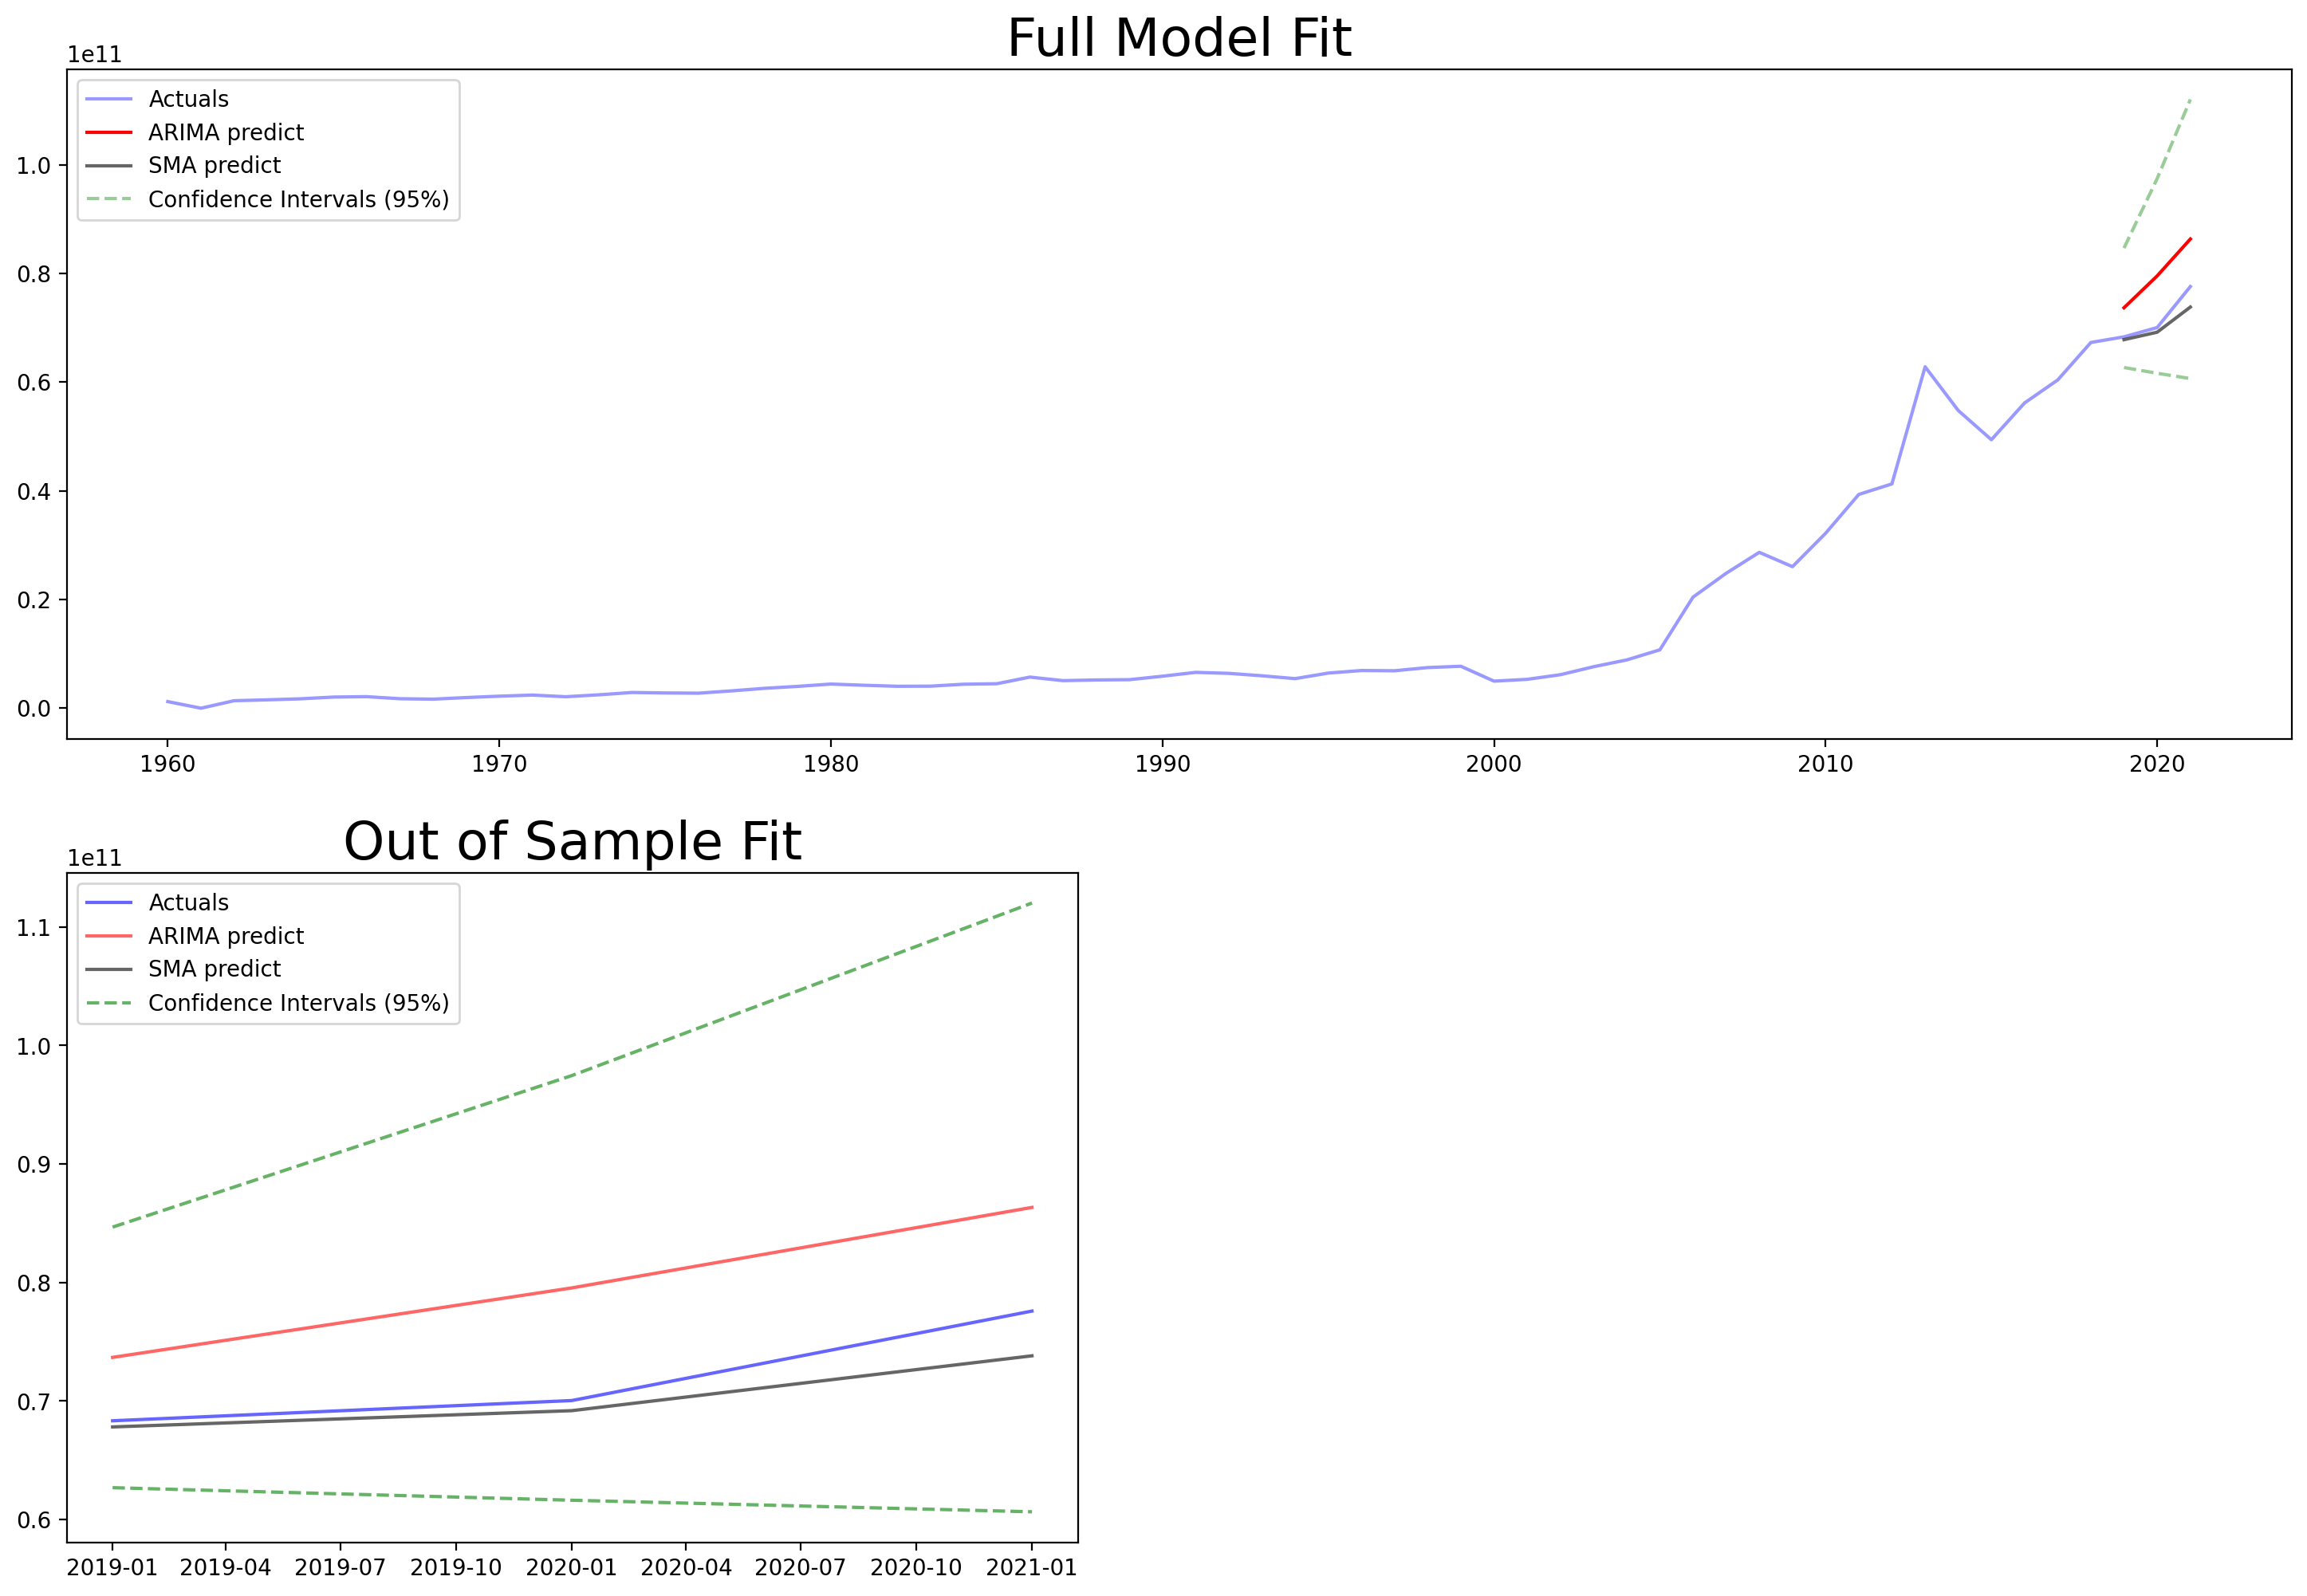

In [15]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="ARIMA predict",
)

plt.plot(
    pred_df.loc[test_df.index]["SMA_predict"],
    color="black",
    linestyle="-",
    label="SMA predict",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="ARIMA predict",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["SMA_predict"],
    color="black",
    linestyle="-",
    label="SMA predict",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

**Выводы:**
- Реальные значения ВВП находятся в интервалах прогнозирования модели ARIMA
- Прогнозные значения модели ARIMA выше реальных
- Прогнозные значения SMA ниже реальных
- По данным метрики MSE и анализу графика видно, что SMA более точно предсказывает ВВП: расхождения с реальными значениями ниже, более точно повторяется движение ряда
- Однако стоит отметить, что тестовая выборка - это только 3 значения из общих данных (где всего 62 значения) и на тестовой выборке сохраняется общий тренд, что помогает SMA делать правильный прогноз.

## 6. Интерполяция

### 6.1. Ищем пропуски:

In [16]:
data.asfreq(freq='AS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [17]:
data.isna().sum()

gdp    0
dtype: int64

В данных есть нулевые значения, что по сути - пропуски. Исследуем их.

In [18]:
# заменяем пропуски NaN
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)

In [19]:
data.isna().sum()

gdp    1
dtype: int64

Есть один пропуск (соответствует 1961-01-01), заполняем его, используя интерполяцию.

In [20]:
data['gdp'] = data['gdp'].interpolate(method='linear')

### 6.2. Проверка на стационарность

In [21]:
# повторно выделим тренировочную и тестовую выборки
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":] # последние 3 года
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [22]:
# с помощью теста Дики-Фуллера оценим стационарность временного ряда
adfuller(train_df.gdp)

(0.8030073326980084,
 0.9916845572455876,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

Ряд нестационарен.

Дифференцируем ряд до тех пор, пока он не станет стационарным.

In [23]:
# копируем тестовую выборку
train_df_adfuller = train_df.copy()
# начальный результат теста Дики-Фуллера
test_result = adfuller(train_df_adfuller['gdp'])
# счетчик разностей
i=0

# пока значение теста не станет меньше критического значения при уровне значимости 5%
# дифференцируем временной ряд
while test_result[0] > test_result[4]["5%"]:
    i+=1
    train_df_adfuller['gdp'] = train_df_adfuller['gdp'].diff()
    test_result = adfuller(train_df_adfuller['gdp'].dropna())
    print(f'{i} разность')
    print("adf: ", test_result[0])
    print("p-value: ", test_result[1])
    print("Critical values: ", test_result[4])
    if test_result[0] > test_result[4]["5%"]:
        print("ряд нестационарен\n")
    else:
        print("ряд стационарен\n")

1 разность
adf:  -1.8255652246435996
p-value:  0.3678451527656344
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен

2 разность
adf:  -2.634634746007851
p-value:  0.08604813722197507
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен

3 разность
adf:  -4.825603687304069
p-value:  4.8573180767989286e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен



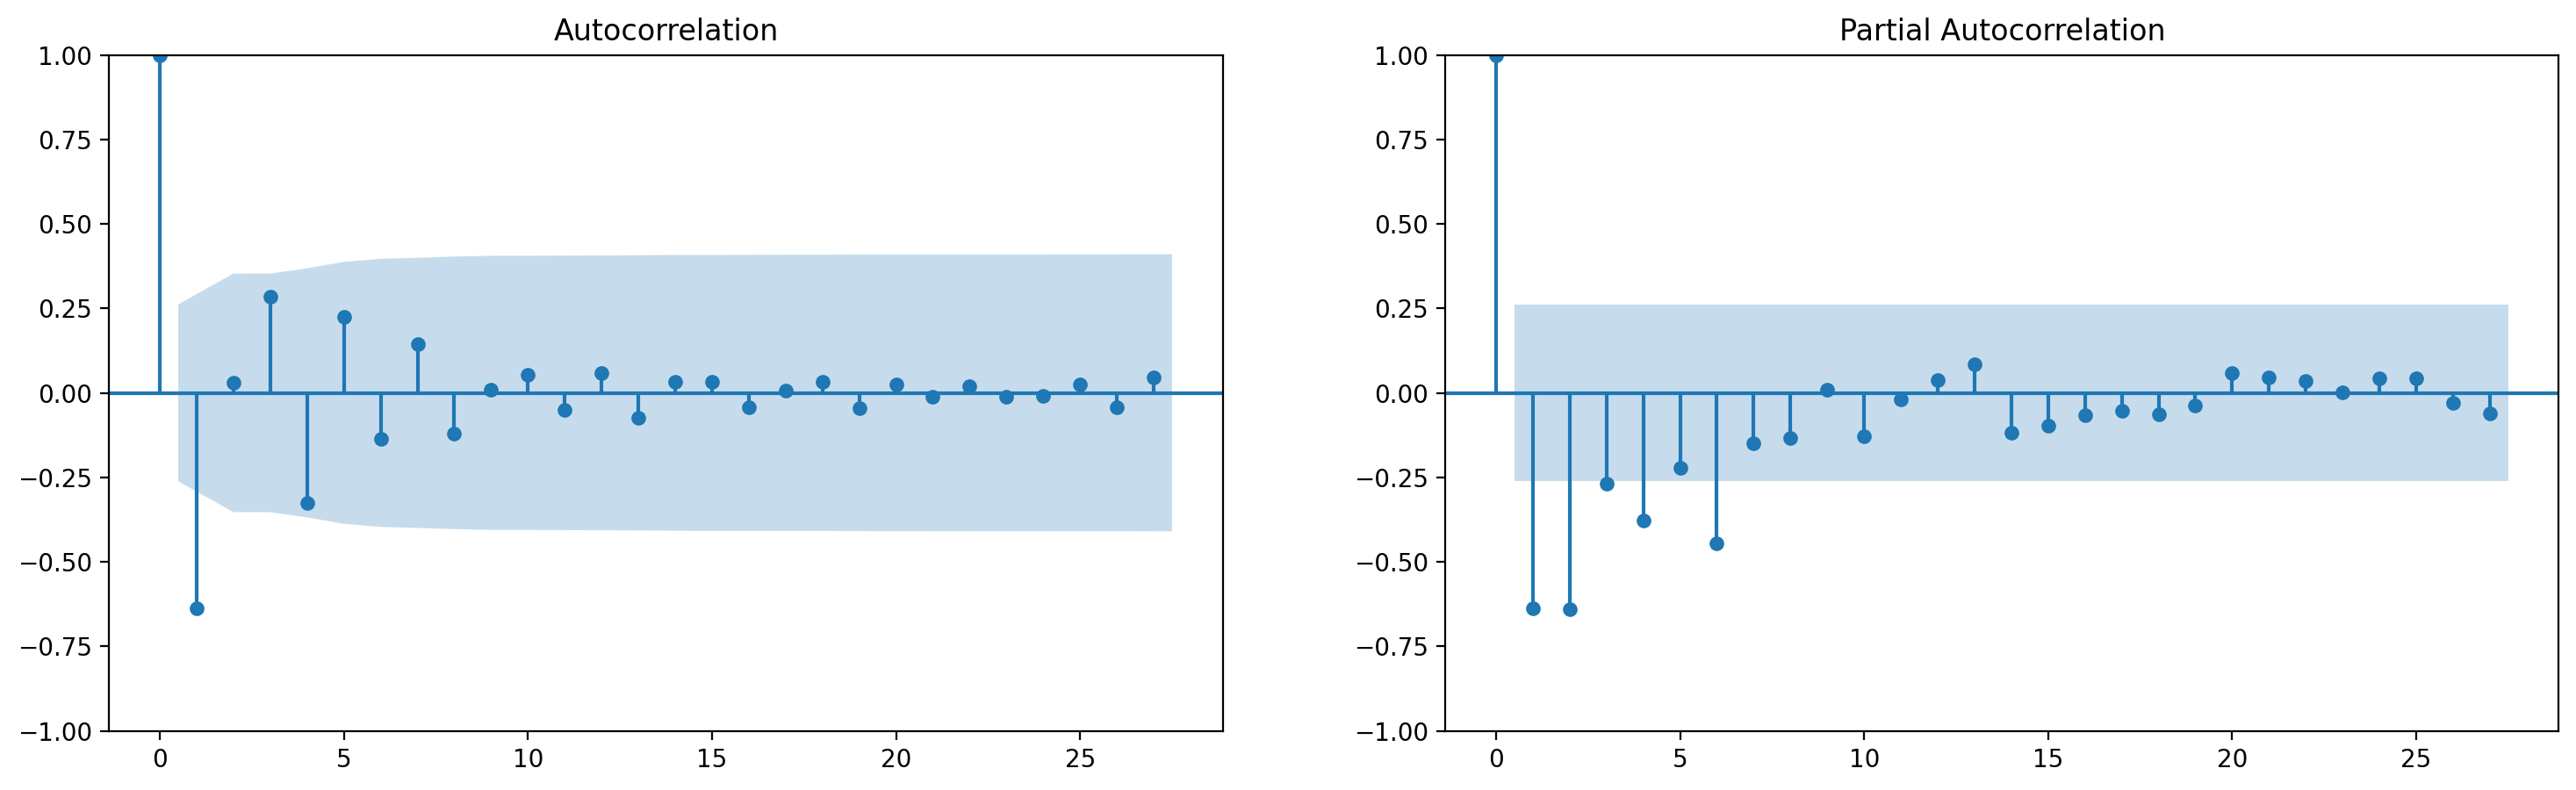

In [24]:
# выведем коррелограммы интегрированного ряда 3 порядка (он уже стационарен!)
plot_acf_pacf(train_df['gdp'].diff().diff().diff().dropna())

По итогу, мы имеем те же параметры модели, что и раньше.

### 6.3. Подбор параметров модели

In [25]:
# обучаем модель
arima_model_2 = ARIMA(train_df["gdp"].dropna(), order=(2, 3, 1))
arima_model_2_fit = arima_model.fit()
arima_model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 27 Jun 2023   AIC                           2659.231
Time:                        19:02:15   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+56. Standard errors may be unstable.
"""

In [26]:
# подбор параметров ARIMA
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=3,
    D=1,
    start_P=0,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.350 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Tue, 27 Jun 2023   AIC                           2659.226
Time:                        19:02:15   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+56. Standard errors may be unstable.
"""

**Выводы:**
- В данных был обнаружен 1 пропуск (нулевое значение ВВП), котрый был заполнен значением, полученным методом интерполяции.
- Новая модель по показателям идентична предыдущей.
- Вероятная причина - наличие только одного пропуска и, как следствие, его незначительное влияние на временной ряд. Кроме того, этот пропуск в начале данных, где значение ВВП больше близки к нулю, чем в конце временного ряда.

## 7. Волатильность

Наша цель - прогноз дисперсии.

In [27]:
# вычисляем волатильность
# data["gdp_vol"] = (data.gdp - data.gdp.shift(1))/data.gdp.shift(1) # 1 вариант
data["gdp_vol"] = data.gdp.pct_change(1).mul(100).abs() # 2 вариант
data["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

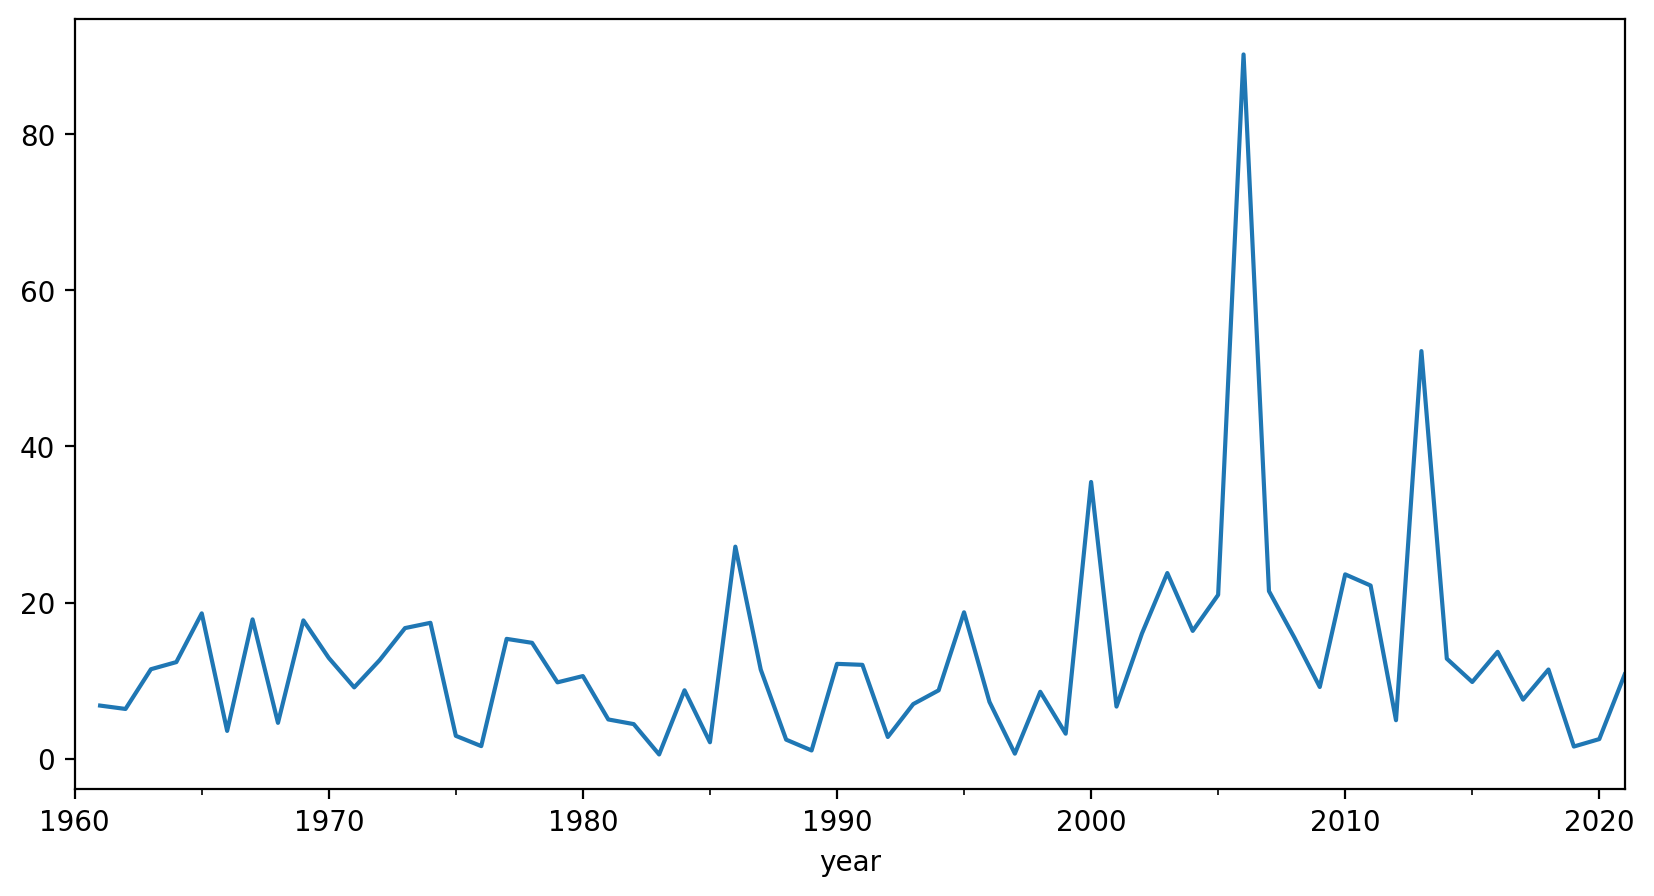

In [28]:
# визуализируем результат
data["gdp_vol"].plot(figsize=(10,5))
plt.show()

In [29]:
# повторно выделим тренировочную и тестовую выборки
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":] # последние 3 года
train_df.shape, test_df.shape

((59, 2), (3, 2))

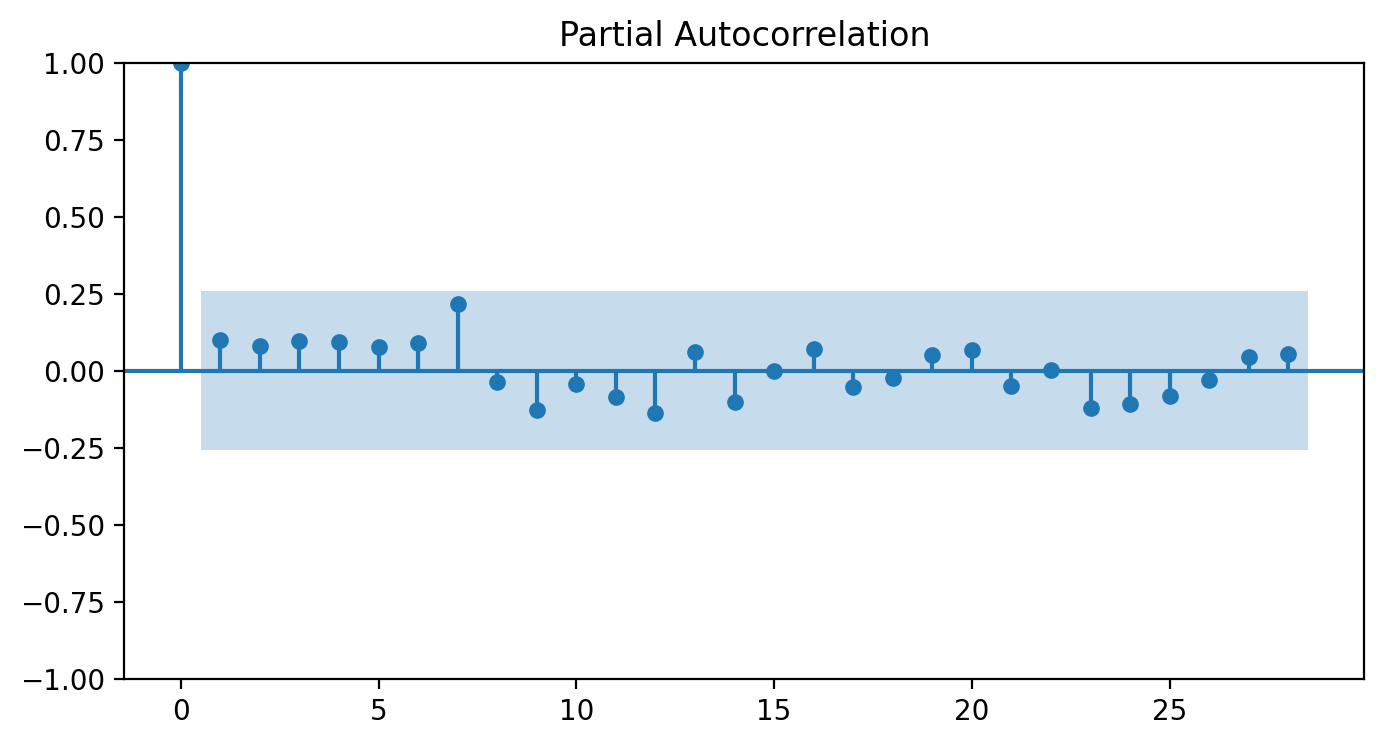

In [30]:
# коррелограмма частичной автокореляции
plt.rcParams["figure.figsize"] = 8, 4

sgt.plot_pacf(train_df.gdp_vol[1:], lags=28, method="ywm")
plt.show()

Хм... Полагаю, что надо взять 1-й лаг и попробовать перебор до 7.      
По итогу, на сколько я понял, **q**=1 (ориентируемся на корреллограмму автокореляции стационарного временного ряда ВВП выше), а **p**=1 (ориентируемся на коррелограмму частичной автокореляции волатильного значения ВВП), но можно попробовать перебор до 7.

In [31]:
# тест Дики-Фуллера
adfuller(train_df.gdp_vol[1:])

(-6.725311059553778,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд стационарен.

In [32]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

Обучаем модель.

In [33]:
model = arch_model(garch_df["gdp_vol"].dropna(), p=7, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.5584527057229
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28340697433651
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57944818513846
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.57263014796456
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075112415614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.55074705232644
            Iterations: 27
            Function evaluations: 308
            Gradient evaluations: 27


In [34]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -213.551
Distribution:                  Normal   AIC:                           447.101
Method:            Maximum Likelihood   BIC:                           467.706
                                        No. Observations:                   58
Date:                Tue, Jun 27 2023   Df Residuals:                       57
Time:                        19:02:16   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.0952      0.833     13.322  1.730e-40 [  9.463, 12.728]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         24.5309     15.324      1.601      0.109      [ -5.504, 54.566]
alpha[1]       0.0000  4.702e-03      0.000      1.000 [-9.216e-03,9.216e-03]
alpha[2]       0.0000  1.594e-02      0.000      1.000 [-3.123e-02,3.123e-02]
alpha[3]       0.3634      0.315      1.155      0.248      [ -0.253,  0.980]
alpha[4]   3.8345e-04      0.121  3.174e-03      0.997      [ -0.236,  0.237]
alpha[5]       0.0000  7.455e-03      0.000      1.000 [-1.461e-02,1.461e-02]
alpha[6]       0.5534      0.387      1.430      0.153      [ -0.205,  1.312]
alpha[7]       0.0829      0.229      0.362      0.717      [ -0.366,  0.531]
beta[1]        0.0000      0.338      0.000      1.000      [ -0.663,  0.663]
=============================================================================

Covariance estimator: robust
"""

**Примечание:** значения параметров модели **p**=7 и **q**=1 получены методом перебора, ориентируясь на минимальное значение AIC.

In [35]:
# создаем новый датафрейм копируя тестовую выборку
predictions_df = test_df.copy()
# создаем признак с предсказанием волатильности
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

**Примечание:** Любое обращение к методу forecast() возвращает объект ARCHModelForecast с тремя основными атрибутами:

.mean — условное среднее значение ряда;    
.variance — условная дисперсия прогноза;    
.residual_variance — прогнозируемая условная дисперсия остатков.     

Residual_variance будет отличаться от variance в случаях, когда значения ряда (не дисперсии, а именно сами значения) имеют зависимость от себя в прошлом. В скринкасте для предсказания дисперсии мы используем residual_variance, так как в нашем случае ряд стационарен и residual_variance и variance возвращают одинаковые значения.

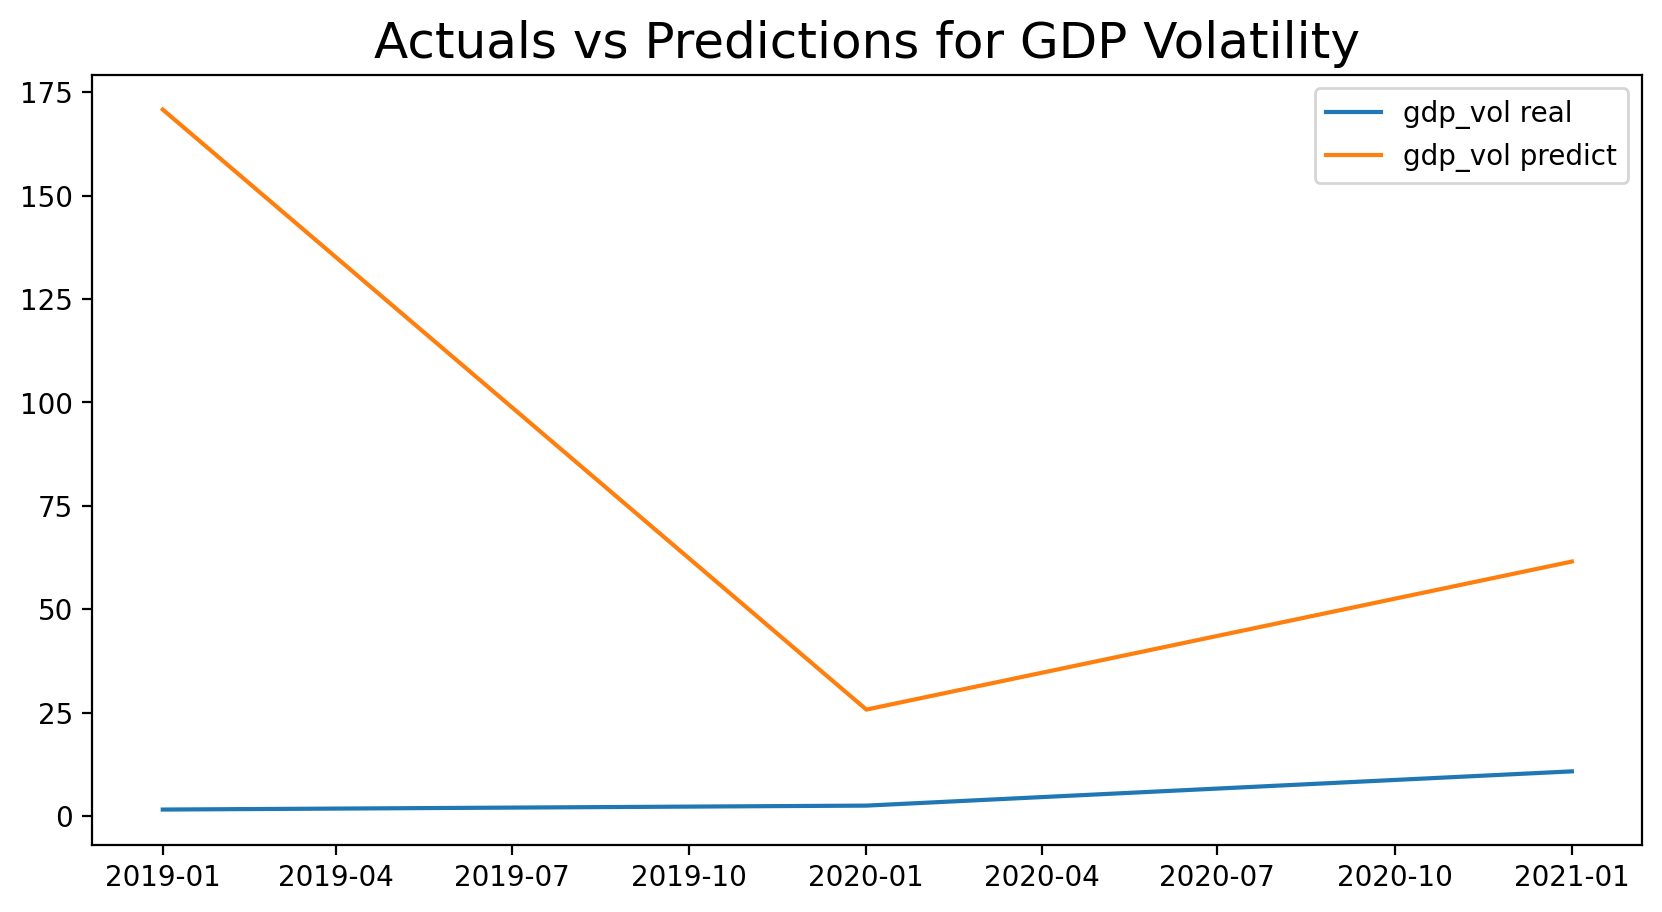

In [36]:
# визуализируем работу модели
plt.rcParams["figure.figsize"] = 10, 5

plt.plot(predictions_df["gdp_vol"].abs(), label='gdp_vol real')
plt.plot(predictions_df["Predictions"], label='gdp_vol predict')

plt.title("Actuals vs Predictions for GDP Volatility", size=18)
plt.legend()
plt.show()

Пробуем линейную регрессию.

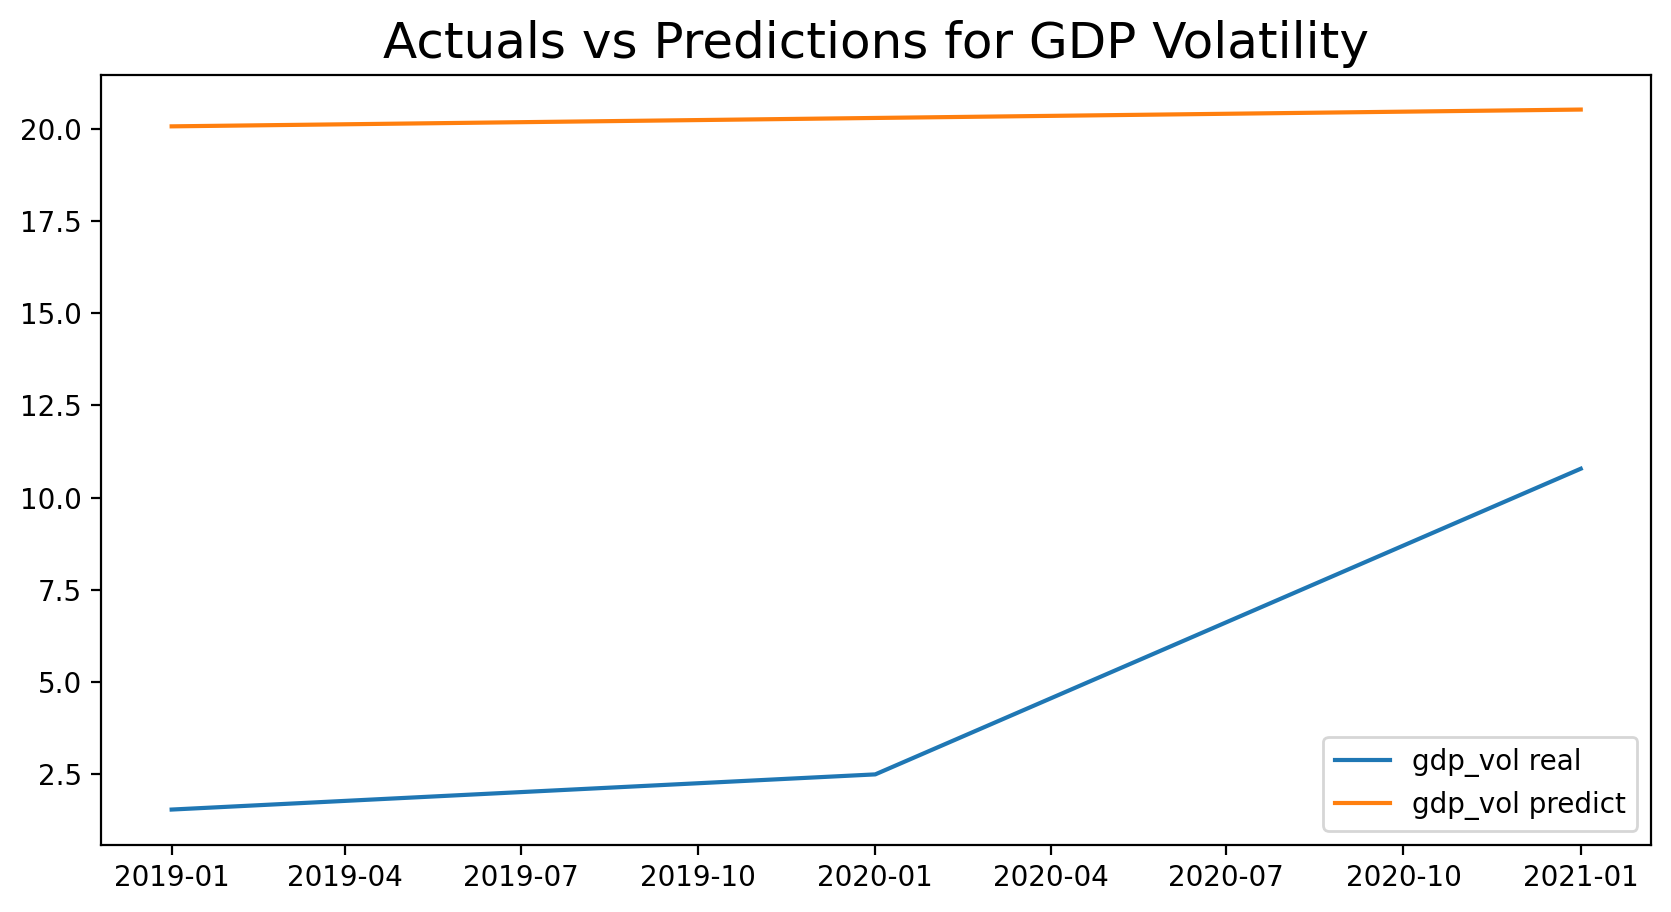

In [37]:
# создаем тренировочную, тестовую выборки и таргет
X_train = pd.DataFrame(range(data['gdp_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['gdp_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['gdp_vol'].fillna(0)
y_test = test_df['gdp_vol'].fillna(0)

# создаем, обучаем модель, делаем предсказание
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

# визуализируем результат работы модели
plt.plot(y_test, label='gdp_vol real')
plt.plot(pd.Series(lr_predict, index=y_test.index), label='gdp_vol predict')
plt.title("Actuals vs Predictions for GDP Volatility", size=18)
plt.legend()
plt.show()

In [38]:
# получаем метрики MSE
mse_garch = mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"])
mse_lr = mean_squared_error(y_test, lr_predict)

print(f'MSE GARCH: {mse_garch}')
print(f'MSE LR: {mse_lr}')

MSE GARCH: 10591.856442147315
MSE LR: 251.40893776471296


**Выводы:**
- Обе модели показали плохой результат предсказания волатильности.
- LR показала себя лучше, чем GARCH, что, вероятно, связано с небольшими по размерам тренировочной и тестовой выборками, что критично для GARCH. К тому же на тестовой выборке имеется явный тренд на рост волатильности, что, вероятно, совпало с предсказанием LR.
- Важен процесс перебора параметров для GARCH, т.к. это сильно влияет на качество предсказаний.